# Attention-based LSTM (AT-LSTM)

В этом ноутбуке мы исследуем применение модели Attention-based LSTM (AT-LSTM) для решения задачи аспектного анализа тональности. В качестве основы мы берем [статью](https://www.aclweb.org/anthology/D16-1058.pdf).

In [1]:
import os
import zipfile
import random

import pandas as pd
import numpy as np
import torch
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
import bs4

from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
from torch.utils.data import Dataset as TorchDataset
from torch.utils.data import DataLoader

from google.colab import drive

USE_GOOGLE_DRIVE = True

sns.set(font_scale=1.2)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Примонтируем наш гугл-диск, если мы решили его использовать.

In [2]:
if USE_GOOGLE_DRIVE:
    drive.mount('/content/drive')
    PATH_PREFIX = 'drive/My Drive/NLP/dialog-sent'
else:
    PATH_PREFIX = '..'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
DATA_PREFIX = os.path.join(PATH_PREFIX, 'data')
MODEL_PREFIX = os.path.join(PATH_PREFIX, 'models')

Зададим девайс для обучения.

In [5]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


Проинициализируем везде генераторы случайных чисел.

In [0]:
random_seed = 42
random_state = random_seed

def set_seed_everywhere(seed, cuda):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if cuda:
        torch.cuda.manual_seed_all(seed)

set_seed_everywhere(random_seed, USE_GPU)

## Повторение результатов статьи

Для того, чтобы применить модель к нашей конкретной задаче для начала надо повторить результаты исследуемой статьи. Будем это делать на примере датасета с [отзывами на рестораны](http://alt.qcri.org/semeval2014/task4/index.php?id=data-and-tools).


### Данные

Теперь надо разобраться с данными. Мы используем отзывы о рестранах. Согласно аннотации к датасету используются следующие аспекты:

* food
* price
* service
* ambience
* anecdotes (sentences describing the reviewer’s personal experience or context, but that do not usually provide information on the restaurant quality e.g. “I knew upon visiting
NYC that I wanted to try an original deli”)
* miscellaneous (sentences that do not belong to the other five categories including sentences that are general recommendations e.g. “Your friends will thank you for introducing them to this gem!”)

Эта же аннотация говорит о том, какие существуют тональности:
* positive
* negative
* conflict (both positive and negative sentiment)
* neutral (neither positive nor negative sentiment)

Помимо этого существует такой объект, как термин аспекта (aspect term) -- это какое-то слово или выражение, которое указывает на то, в каком слове выражается тональность к конкретному аспекту. 

Существует два вида задач для аспектного анализа тональности:
* Aspect-level Classification -- определить тональность для каждого аспекта.
* Aspect-Term-level Classification -- определить термины для каждого аспекта, а затем определить их тональность.

Наша финальная задача относится к первой категории, а значит нам не нужны данные о терминах аспекта.

Теперь определим поля в датасете для обучения.

In [0]:
TEXT = torchtext.data.Field(
    tokenize='spacy', batch_first=True, init_token='<begin>', 
    eos_token='<end>', lower=True
)
ASPECT = torchtext.data.Field(sequential=False, batch_first=True)
SENTIMENT = torchtext.data.LabelField(batch_first=True)

In [0]:
fields = [('text', TEXT), ('aspect', ASPECT), ('sentiment', SENTIMENT)]

In [9]:
data_train_path = os.path.join(DATA_PREFIX, 'processed', 'restaurants_train.csv')
data_test_path = os.path.join(DATA_PREFIX, 'processed', 'restaurants_test.csv')
data_all_path = os.path.join(DATA_PREFIX, 'processed', 'restaurants.csv')

train_data_all = torchtext.data.TabularDataset(
    path=data_train_path, format = 'csv', fields=fields, skip_header=True
)
test_data = torchtext.data.TabularDataset(
    path=data_test_path, format = 'csv', fields=fields, skip_header=True
)
data_all = torchtext.data.TabularDataset(
    path=data_all_path, format = 'csv', fields=fields, skip_header=True
)

print(vars(train_data_all.examples[0]))

{'text': ['but', 'the', 'staff', 'was', 'so', 'horrible', 'to', 'us', '.'], 'aspect': 'service', 'sentiment': '3'}


Разделим данные на обучение и валидацию (для early stopping).

In [0]:
train_data, valid_data = train_data_all.split(
    split_ratio=0.8, random_state=random.seed(random_state)
)

Построим для нашего датасета словарь. Согласно статье, эмбеддинги слов были проинициализированы при помощи GloVe, а для неизвестных слов в качестве эмбеддингов были взяты случайные векторы из $U(-\varepsilon, \varepsilon)$, где $\varepsilon = 0.01$.


In [0]:
epsilon = 0.01
vectors_cache = os.path.join(DATA_PREFIX, 'raw', 'glove')
TEXT.build_vocab(data_all, 
                 vectors='glove.840B.300d', vectors_cache=vectors_cache,
                 unk_init=lambda x: torch.nn.init.uniform_(x, -epsilon, epsilon))
ASPECT.build_vocab(train_data)
SENTIMENT.build_vocab(train_data)

In [12]:
print(f'Size of TEXT vocabulary: {len(TEXT.vocab)}')
print(f'Size of ASPECT vocabulary: {len(ASPECT.vocab)}')
print(f'Size of SENTIMENT vocabulary: {len(SENTIMENT.vocab)}')

Size of TEXT vocabulary: 5041
Size of ASPECT vocabulary: 6
Size of SENTIMENT vocabulary: 3


Теперь напишем итератор.

In [0]:
batch_size = 64

train_iter, val_iter, test_iter = torchtext.data.BucketIterator.splits(
        (train_data, valid_data, test_data),
        batch_sizes=(batch_size, batch_size, batch_size),
        sort=True,
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        device=device,
        repeat=False
)

### Модель

Вспомогательный слой.

In [0]:
class Permute(nn.Module):
    def __init__(self, dims):
        super(Permute, self).__init__()
        self.dims = dims
        
    def forward(self, x):
        x = x.permute(self.dims).contiguous()
        return x

Зададим архитектуру нашей сети.

In [0]:
class AT_LSTM(nn.Module):

    def __init__(
        self, num_aspects, embeddings_aspects_dim, hidden_dim, 
        num_sentiments, 
        vocab_size=None, embeddings_words_dim=None, embeddings_words_init=None
    ):
        super(AT_LSTM, self).__init__()

        train_from_scratch = (vocab_size is not None 
                              and embedding_words_dim is not None)
        use_pretrained = embeddings_words_init is not None
        if not(train_from_scratch or use_pretrained):
            raise ValueError('You should use pretrained vectors or '
                             'set vocab size and embeddings dim')

        if train_from_scratch:
            self.embeddings_words = nn.Embedding(
                vocab_size, embeddings_words_dim
            )
        else:
            self.embeddings_words = nn.Embedding.from_pretrained(
                embeddings_words_init
            )
            vocab_size, embeddings_words_dim = embeddings_words_init.size()

        self.lstm = nn.LSTM(
            embeddings_words_dim, hidden_dim,
            batch_first=True
        )

        self.embeddings_aspects = nn.Embedding(
            num_aspects, embeddings_aspects_dim
        )
        self.attention = nn.Sequential(
            nn.Linear(embeddings_aspects_dim + hidden_dim, 
                      embeddings_aspects_dim + hidden_dim),
            Permute([0, 2, 1]),     
            nn.BatchNorm1d(embeddings_aspects_dim + hidden_dim),
            Permute([0, 2, 1]),
            nn.Dropout(),
            nn.Tanh(),
            nn.Linear(embeddings_aspects_dim + hidden_dim, 1),
            nn.Softmax(dim=1),
        )

        self.sentence_representation = nn.Linear(
            hidden_dim + hidden_dim, hidden_dim, bias=False
        )
        self.drop = nn.Dropout()
        self.sentence_representation_nonlinearity = nn.Tanh()
        self.sentence_representation_to_sentiments = nn.Linear(
            hidden_dim, num_sentiments
        )

        # weights initializatioin
        torch.nn.init.xavier_uniform_(self.embeddings_aspects.weight)
        torch.nn.init.xavier_uniform_(self.sentence_representation.weight)
        torch.nn.init.xavier_uniform_(self.sentence_representation_to_sentiments.weight)

        
    def forward(self, texts, aspects, hidden=None):
        batch_size, seq_len = texts.size()
        # shape: [batch_size, seq_len] -> [batch_size, seq_len, embeddings_words_dim]
        embeddings_words_out = self.embeddings_words(texts)
        # shape: [batch_size] -> [batch_size, seq_len, embedding_aspects_dim]
        embeddings_aspects_out = self.embeddings_aspects(aspects)
        embeddings_aspects_out = torch.unsqueeze(embeddings_aspects_out, 1)
        embeddings_aspects_out = torch.repeat_interleave(
            embeddings_aspects_out, seq_len, 1
        )
        # shape: [batch_size, seq_len, embeddings_dim] -> [batch_size, seq_len, hidden_dim]
        lstm_output, hidden_state = self.lstm(embeddings_words_out, hidden)

        attention_input = torch.cat(
            [lstm_output, embeddings_aspects_out], dim=-1,
        )
        # shape: [batch_size, seq_len, hidden_dim + embeddings_aspects_dim] -> [batch_size, seq_len]
        attention_weights = self.attention(attention_input)
        weighted_lstm_output = lstm_output.permute(0, 2, 1) @ attention_weights
        weighted_lstm_output = torch.squeeze(weighted_lstm_output, dim=-1)
        sentence_representation = torch.cat([lstm_output[:, -1, :], 
                                             weighted_lstm_output], dim=-1)
        sentence_representation = self.sentence_representation(
            sentence_representation
        )
        sentence_representation = self.drop(sentence_representation)
        sentence_representation = self.sentence_representation_nonlinearity(
            sentence_representation
        )
        # shape: [batch_size, hidden_size] -> [batch_size, num_sentiments]
        sentiments_scores = self.sentence_representation_to_sentiments(
            sentence_representation
        )
        return sentiments_scores, hidden_state

Возьмем параметры, как в статье: `embeddings_aspects_dim=300`, `hidden_dim=300`.

In [16]:
num_aspects = len(ASPECT.vocab)
embeddings_aspects_dim = 300
hidden_dim = 300
num_sentiments = len(SENTIMENT.vocab)
embeddings_words_init = TEXT.vocab.vectors

set_seed_everywhere(random_seed, USE_GPU)
model = AT_LSTM(
    num_aspects, embeddings_aspects_dim, hidden_dim, num_sentiments, 
    embeddings_words_init=embeddings_words_init
)
model

AT_LSTM(
  (embeddings_words): Embedding(5041, 300)
  (lstm): LSTM(300, 300, batch_first=True)
  (embeddings_aspects): Embedding(6, 300)
  (attention): Sequential(
    (0): Linear(in_features=600, out_features=600, bias=True)
    (1): Permute()
    (2): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Permute()
    (4): Dropout(p=0.5, inplace=False)
    (5): Tanh()
    (6): Linear(in_features=600, out_features=1, bias=True)
    (7): Softmax(dim=1)
  )
  (sentence_representation): Linear(in_features=600, out_features=300, bias=False)
  (drop): Dropout(p=0.5, inplace=False)
  (sentence_representation_nonlinearity): Tanh()
  (sentence_representation_to_sentiments): Linear(in_features=300, out_features=3, bias=True)
)

### Тренировочный цикл

Здесь мы реализуем тренировочный цикл для нашей модели. По идее нужны momentum, как в статье, равный $0.9$ для Adam установлен автоматически. Здесь же установим и коэффициент l2-регляризации для оптимизитора: $0.001$.

In [0]:
model = model.to(device=device)
learning_rate = 1e-5
early_stopping = 1000
grad_clipping_value = 1
l2_coef = 1e-3
epochs = 200

opt = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_coef)
scheduler = optim.lr_scheduler.StepLR(opt, step_size=10, gamma=1)
criterion = nn.CrossEntropyLoss()
path_save = os.path.join(MODEL_PREFIX, 'at_lstm', 'at_lstm.pt')

In [0]:
def train_loop(train_iter, val_iter, model, opt, scheduler, criterion, epochs, 
               early_stopping):
    train_losses = []
    val_losses = []
    train_acc_values = []
    val_acc_values = []
    best_val_loss = 10
    best_val_acc = 0
    not_improves = 0
    for epoch in tqdm(range(1, epochs + 1)):
        train_loss = 0.0
        train_acc = 0
        model.train() 
        for batch in train_iter: 

            texts = batch.text.to(device=device)
            aspects = batch.aspect.to(device=device)
            sentiments = batch.sentiment.to(device=device)

            opt.zero_grad()
            preds, _ = model(texts, aspects)

            loss = criterion(preds, sentiments)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), grad_clipping_value)
            opt.step()
            train_loss += loss.item()

            pred_sentiments = torch.max(preds, dim=-1)[1]
            train_acc += np.sum(
                pred_sentiments.cpu().numpy() == sentiments.cpu().numpy()
            )

        train_loss /= len(train_data)
        train_losses.append(train_loss)
        train_acc /= len(train_data)
        train_acc_values.append(train_acc)

        val_loss = 0.0
        val_acc = 0
        model.eval()
        with torch.no_grad():
            for batch in val_iter:

                texts = batch.text.to(device=device)
                aspects = batch.aspect.to(device=device)
                sentiments = batch.sentiment.to(device=device)

                preds, _ = model(texts, aspects)   
                loss = criterion(preds, sentiments)
                val_loss += loss.item()

                pred_sentiments = torch.max(preds, dim=-1)[1]
                val_acc += np.sum(
                    pred_sentiments.cpu().numpy() == sentiments.cpu().numpy()
                )

        val_loss /= len(valid_data)
        val_acc /= len(valid_data)
        val_losses.append(val_loss)
        val_acc_values.append(val_acc)

        if val_acc > best_val_acc:
            not_improves = 0
            best_val_acc = val_acc
            torch.save(model.state_dict(), path_save)
            print('------SAVED------')
        else:
            not_improves += 1
            if not_improves == early_stopping:
                break
        
        scheduler.step()

        print(f'Epoch: {epoch}, '
              f'Training Loss*: {1000*train_loss:.5f}, '
              f'Validation Loss*: {1000*val_loss:.5f}, \n'
              f'Training Acc: {train_acc:.5f}, '
              f'Validation Acc: {val_acc:.5f}')

    return train_losses, val_losses, train_acc_values, val_acc_values

In [19]:
set_seed_everywhere(random_seed, USE_GPU)
train_losses, val_losses, train_acc, val_acc = train_loop(
    train_iter, val_iter, model, opt, scheduler, criterion, 
    epochs, early_stopping
)

------SAVED------
Epoch: 1, Training Loss*: 16.59946, Validation Loss*: 15.97463, 
Training Acc: 0.50658, Validation Acc: 0.61735
Epoch: 2, Training Loss*: 15.29555, Validation Loss*: 14.97465, 
Training Acc: 0.61998, Validation Acc: 0.61735
Epoch: 3, Training Loss*: 14.53933, Validation Loss*: 14.48003, 
Training Acc: 0.61962, Validation Acc: 0.61735
Epoch: 4, Training Loss*: 14.14587, Validation Loss*: 14.25369, 
Training Acc: 0.61962, Validation Acc: 0.61735
Epoch: 5, Training Loss*: 13.96726, Validation Loss*: 14.10017, 
Training Acc: 0.61962, Validation Acc: 0.61735
Epoch: 6, Training Loss*: 13.79048, Validation Loss*: 13.94536, 
Training Acc: 0.61962, Validation Acc: 0.61735
Epoch: 7, Training Loss*: 13.60785, Validation Loss*: 13.77864, 
Training Acc: 0.61962, Validation Acc: 0.61735
Epoch: 8, Training Loss*: 13.40648, Validation Loss*: 13.59791, 
Training Acc: 0.61962, Validation Acc: 0.61735
Epoch: 9, Training Loss*: 13.19902, Validation Loss*: 13.41090, 
Training Acc: 0.61962

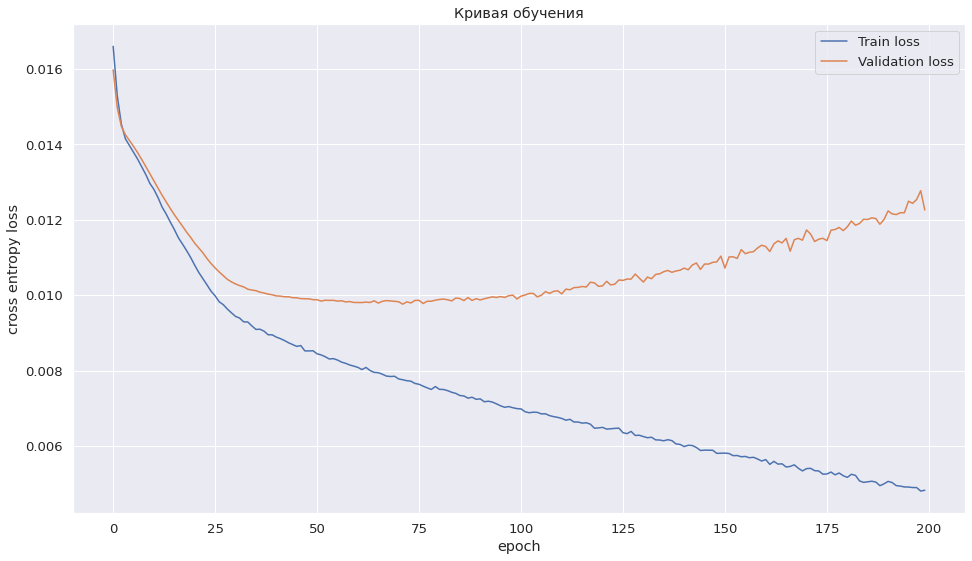

In [20]:
plt.figure(figsize=(16, 9))
finished_epochs = len(train_losses)
plt.plot(np.arange(finished_epochs), train_losses, label='Train loss')
plt.plot(np.arange(finished_epochs), val_losses, label='Validation loss')
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')
plt.title('Кривая обучения')
plt.legend()
plt.show()

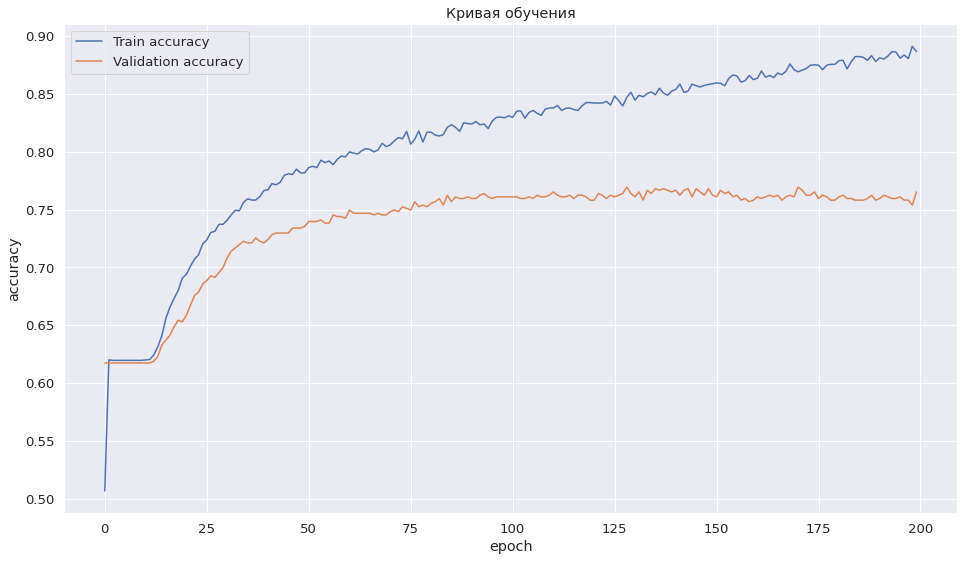

In [21]:
plt.figure(figsize=(16, 9))
finished_epochs = len(train_losses)
plt.plot(np.arange(finished_epochs), train_acc, label='Train accuracy')
plt.plot(np.arange(finished_epochs), val_acc, label='Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Кривая обучения')
plt.legend()
plt.show()

Измерим качество полученной модели.

In [22]:
model.load_state_dict(torch.load(path_save))

<All keys matched successfully>

In [0]:
model.eval()

all_preds = []
all_answers = []
with torch.no_grad():
    for batch in test_iter:

        texts = batch.text.to(device=device)
        aspects = batch.aspect.to(device=device)
        sentiments = batch.sentiment.to(device=device)

        preds_scores, _ = model(texts, aspects)
        preds = torch.max(preds_scores, dim=-1)[1]
        all_preds += preds.tolist()
        all_answers += sentiments.tolist()

all_preds = np.array(all_preds)
all_answers = np.array(all_answers)

In [24]:
accuracy = accuracy_score(all_preds, all_answers)

print(f'Accuracy: {accuracy:.5f}')

Accuracy: 0.81912


### Какие были эксперименты

1. Установка Dropout перед выходом.
2. Пробовал сменить нелинейные функции, оказалось, что tanh работал в основном лучше.
3. Большое улучшение дал BatchNorm + Dropout внутри Attention.